### Experiments with training spectral bias

Imports

In [83]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim
import heapq
import os
from datetime import datetime
import argparse
import torch.nn.functional as F

Set save to True if you want to save plots

In [46]:
save = True

Only for python script: uncomment if running on cluster

In [3]:
# These are both placeholders
num_epochs = 1000
model_name = f0

In [4]:
# # Parse command-line arguments
# parser = argparse.ArgumentParser(description='Train a neural network model')
# parser.add_argument('--epochs', type=int, default=1000, help='Number of training epochs')
# parser.add_argument('--model_name', type=str, default='model', help='Name of the saved model')
# args = parser.parse_args()

# # Use the parsed arguments
# num_epochs = args.epochs
# model_name = args.model_name

Check if CUDA is available

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [6]:
# For reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

Base dataset class

In [7]:
class BaseFourierDataset(Dataset):
    def __init__(self, num_samples, num_points, max_freq):
        self.num_samples = num_samples
        self.num_points = num_points
        self.max_freq = max_freq
        self.x = torch.linspace(0, 2*np.pi, num_points, requires_grad=True)
        self.functions, self.first_derivatives = self.generate_data()

    def complex_fourier_series(self, x, c, P=2*np.pi):
        result = torch.zeros_like(x, dtype=torch.complex64)
        n_terms = (len(c) - 1) // 2
        for n in range(-n_terms, n_terms+1):
            result += c[n + n_terms] * torch.exp(1j * 2 * np.pi * n * x / P)
        return result.real

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Can exclude the first element with the large derivative using [1:]
        # return torch.FloatTensor(self.functions[idx][1:]), torch.FloatTensor(self.first_derivatives[idx][1:])
        return torch.FloatTensor(self.functions[idx]), torch.FloatTensor(self.first_derivatives[idx])

    def generate_data(self):
        raise NotImplementedError("Subclasses must implement generate_data method")

In [8]:
class LowFrequencyFourierDataset(BaseFourierDataset):
    def __init__(self, num_samples, num_points, max_freq=5):
        super().__init__(num_samples, num_points, max_freq)

    def generate_data(self):
        functions, first_derivatives = [], []

        for _ in range(self.num_samples):
            # Generate coefficients only for low frequencies (1 to max_freq)
            c = torch.zeros(2*self.max_freq+1, dtype=torch.complex64)
            c[self.max_freq-self.max_freq:self.max_freq+self.max_freq+1] = torch.complex(torch.randn(2*self.max_freq+1), torch.randn(2*self.max_freq+1))

            # Compute function values
            y = self.complex_fourier_series(self.x, c)
            # y = y - y[0]  # Ensure f(0) = 0
            functions.append(y.detach().numpy())

            # Compute derivatives
            dy_dx = torch.autograd.grad(y, self.x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
            first_derivatives.append(dy_dx.detach().numpy())

        return np.array(functions), np.array(first_derivatives)

class HighFrequencyFourierDataset(BaseFourierDataset):
    def __init__(self, num_samples, num_points, min_freq=15, max_freq=20):
        self.min_freq = min_freq
        super().__init__(num_samples, num_points, max_freq)

    def generate_data(self):
        functions, first_derivatives = [], []

        for _ in range(self.num_samples):
            # Generate coefficients
            c = torch.zeros(2*self.max_freq+1, dtype=torch.complex64)
            high_freq_coeffs = torch.complex(torch.randn(self.max_freq-self.min_freq+1), 
                                            torch.randn(self.max_freq-self.min_freq+1))
            c[self.max_freq+self.min_freq:] = high_freq_coeffs
            c[:self.max_freq-self.min_freq+1] = torch.conj(high_freq_coeffs.flip(0))

            # Compute function values
            y = self.complex_fourier_series(self.x, c)
            # y = y - y[0]  # Ensure f(0) = 0

            # Compute derivatives
            dy_dx = torch.autograd.grad(y, self.x, grad_outputs=torch.ones_like(y), create_graph=True)[0]

            functions.append(y.detach().numpy())
            first_derivatives.append(dy_dx.detach().numpy())

        return np.array(functions), np.array(first_derivatives)


In [9]:
class GeneralFrequencyFourierDataset(BaseFourierDataset):
    def __init__(self, num_samples, num_points, max_freq=random.randrange(20)):
        super().__init__(num_samples, num_points, max_freq)

    def generate_data(self):
        functions, first_derivatives = [], []

        for _ in range(self.num_samples):
            # Generate coefficients only for low frequencies (1 to max_freq)
            c = torch.zeros(2*self.max_freq+1, dtype=torch.complex64)
            c[self.max_freq-self.max_freq:self.max_freq+self.max_freq+1] = torch.complex(torch.randn(2*self.max_freq+1), torch.randn(2*self.max_freq+1))

            # Compute function values
            y = self.complex_fourier_series(self.x, c)
            # y = y - y[0]  # Ensure f(0) = 0
            functions.append(y.detach().numpy())

            # Compute derivatives
            dy_dx = torch.autograd.grad(y, self.x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
            first_derivatives.append(dy_dx.detach().numpy())

        return np.array(functions), np.array(first_derivatives)

Uncomment the below to generate the datasets for the first time. After saving the datasets, they can be loaded in for future use.

In [10]:
num_samples = 500
num_points = 1000

# general_freq_dataset = GeneralFrequencyFourierDataset(num_samples, num_points)
# low_freq_dataset = LowFrequencyFourierDataset(num_samples, num_points, max_freq=5)
# high_freq_dataset = HighFrequencyFourierDataset(num_samples, num_points, min_freq=20, max_freq=30)

# # Create DataLoaders
# batch_size = 32
# general_dataloader = DataLoader(general_freq_dataset, batch_size=batch_size, shuffle=True)
# low_freq_dataloader = DataLoader(low_freq_dataset, batch_size=batch_size, shuffle=True)
# high_freq_dataloader = DataLoader(high_freq_dataset, batch_size=batch_size, shuffle=True)

# # Save datasets
# torch.save(general_freq_dataset, 'datasets/general_freq_dataset.pt')
# torch.save(low_freq_dataset, 'datasets/low_freq_dataset.pt')
# torch.save(high_freq_dataset, 'datasets/high_freq_dataset.pt')

General frequency dataset

In [11]:
dataset_g = torch.load('../../datasets/general_freq_dataset.pt')
total_size = len(dataset_g)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(seed)
train_dataset_g, test_dataset_g = random_split(dataset_g, [train_size, test_size], generator=generator)
train_dataloader_g = DataLoader(train_dataset_g, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_g = DataLoader(test_dataset_g, batch_size=32, shuffle=False, drop_last=True)

Low frequency dataset

In [12]:
dataset_l = torch.load('../../datasets/low_freq_dataset.pt')
total_size = len(dataset_l)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(seed)
train_dataset_l, test_dataset_l = random_split(dataset_l, [train_size, test_size], generator=generator)
train_dataloader_l = DataLoader(train_dataset_l, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_l = DataLoader(test_dataset_l, batch_size=32, shuffle=False, drop_last=True)

High frequency dataset

In [13]:
dataset_h = torch.load('../../datasets/high_freq_dataset.pt')
total_size = len(dataset_h)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(seed)
train_dataset_h, test_dataset_h = random_split(dataset_h, [train_size, test_size], generator=generator)
train_dataloader_h = DataLoader(train_dataset_h, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_h = DataLoader(test_dataset_h, batch_size=32, shuffle=False, drop_last=True)

## Plot a function

Low freq function

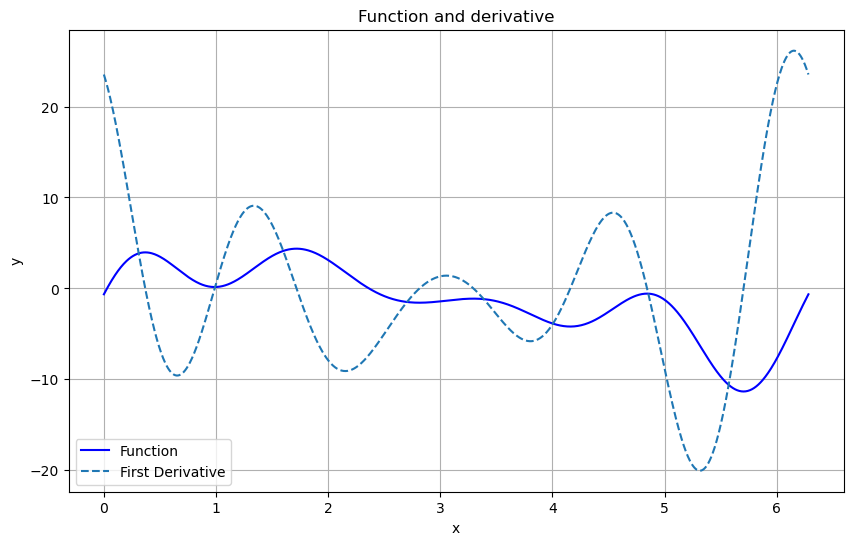

In [14]:
def plot_function_and_derivative(dataloader):
    # Get a single sample from the dataloader
    dataiter = iter(dataloader)
    function, derivative = next(dataiter)

    # Since we're dealing with batches, let's take the first item in the batch
    function = function[0].numpy()
    derivative = derivative[0].numpy()

    # Create x-axis values (assuming the domain is [0, 2π])
    x = torch.linspace(0, 2*torch.pi, len(function)).numpy()

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(x, function, label='Function', color='blue')
    plt.plot(x, derivative, label='First Derivative', linestyle='--')
    
    plt.title('Function and derivative')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    
    plt.show()

def get_random_function(dataset, shuffle=True):
    return DataLoader(dataset, batch_size=1, shuffle=shuffle)

train_dataloader_viz = get_random_function(dataset=train_dataset_l, shuffle=True)
plot_function_and_derivative(train_dataloader_viz)

General freq function

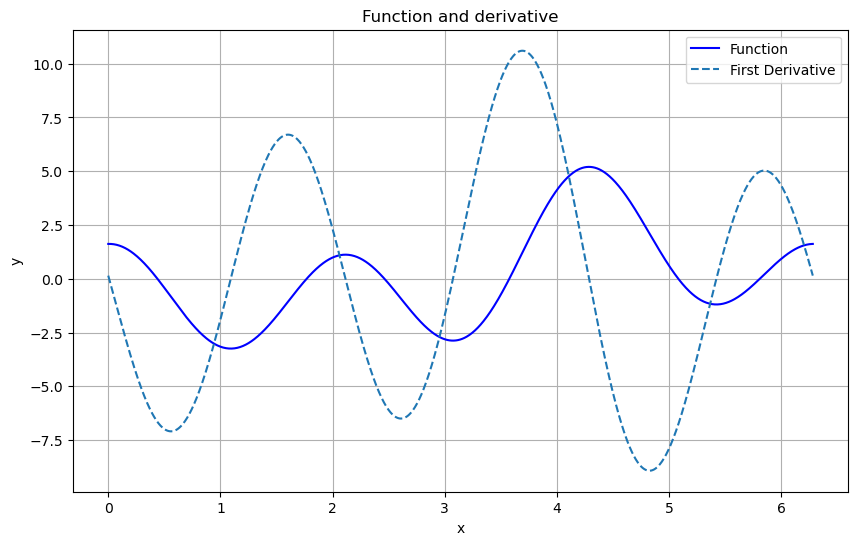

In [15]:
train_dataloader_viz = get_random_function(dataset=train_dataset_g, shuffle=True)
plot_function_and_derivative(train_dataloader_viz)

High freq function

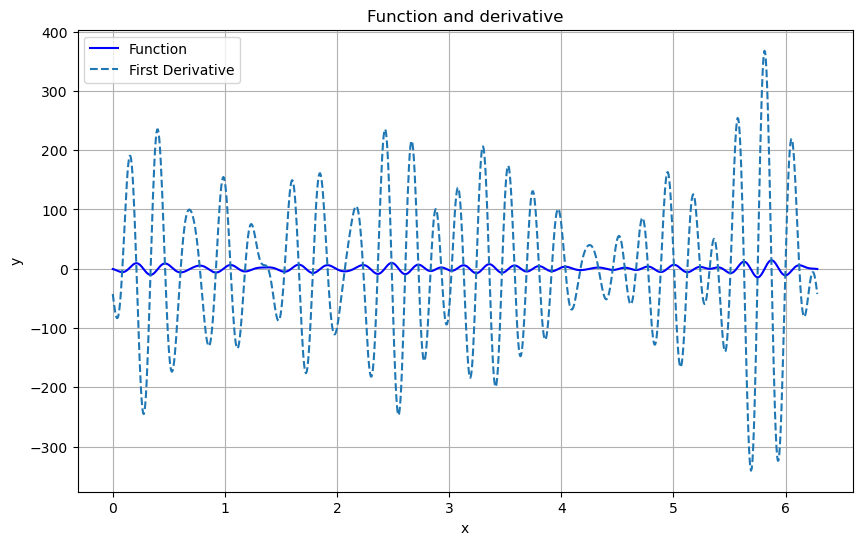

In [16]:
train_dataloader_viz = get_random_function(dataset=train_dataset_h, shuffle=True)
plot_function_and_derivative(train_dataloader_viz)

## Model architecture

This CNN uses 3 layers, each with kernel size 3

In [17]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [18]:
f0 = SimpleCNN()
criterion = nn.MSELoss()

To use the previously trained model, uncomment below

In [19]:
# f0.load_state_dict(torch.load('models/f0_E1000_standardized.pth'))

## Miscellaneous plotting functions

In [20]:
def plot_losses(train_losses, test_losses, save_dir='plots', filename=None, save=False):
    if not train_losses:
        return
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    current_date = datetime.now().strftime("%m-%d")
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, linestyle='-', color='b', label='Training Loss')
    plt.plot(epochs, test_losses, linestyle='-', label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')  # Set the y-axis to logarithmic scale
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"
    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)    
    plt.show()

In [21]:
def plot_output(model1, dataset, order=None, save_dir='plots', filename=None, save=False): 
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    current_date = datetime.now().strftime("%m-%d")
    model1.eval()  # Set the model to evaluation mode

    train_dataloader_viz = get_random_function(dataset, shuffle=True)
    # Get a random sample from the dataloader
    dataiter = iter(train_dataloader_viz)
    function, true_derivative = next(dataiter)

    # Reshape the input for the model
    function = function.unsqueeze(1)  # Add channel dimension

    # Make prediction
    with torch.no_grad():
        if order == 1 or order == 2:
            predicted_derivative = model1(function)
        
        if order == 'rollout':
            predicted_derivative = model1(function)
            predicted_derivative = model1(predicted_derivative)

    # Convert tensors to numpy arrays for plotting
    x = torch.linspace(0, 2*torch.pi, 1000).numpy()
    function = function.squeeze().numpy()

    predicted_derivative = predicted_derivative.squeeze().numpy()

    true_derivative = true_derivative.squeeze().numpy()

    # Plot the results
    plt.figure(figsize=(12, 6))

    plt.plot(x, function, label='Original Function', color='blue')
    if order == 1:
        plt.plot(x, true_derivative, label=f'True {order}st derivative')

    plt.plot(x[10:-10], predicted_derivative[10:-10], label=f'Predicted {order}nd Derivative', linestyle='--')

    plt.title('Function, True Derivatives, and Predicted Derivatives')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"

    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)  
    plt.show()

## Plot results

Low frequency output

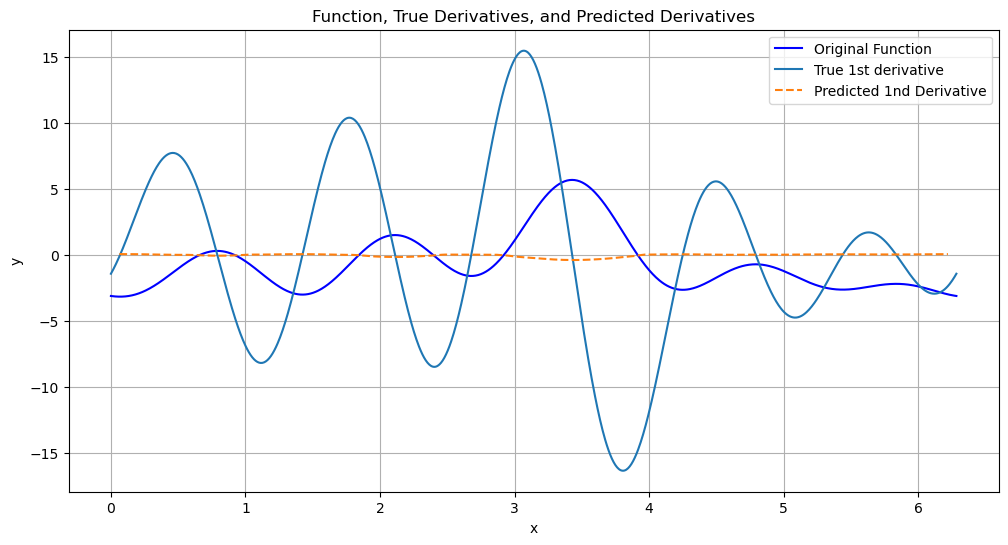

In [22]:
plot_output(f0, dataset=train_dataset_l, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)

General frequency output

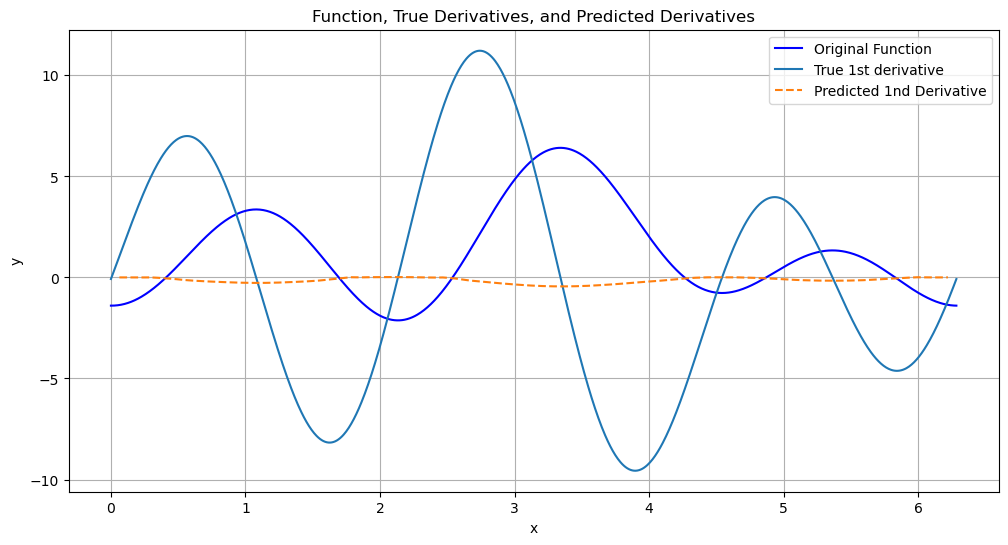

In [23]:
plot_output(f0, dataset=train_dataset_g, order=1, save_dir='..plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_gf_output', save=save)

High frequency output

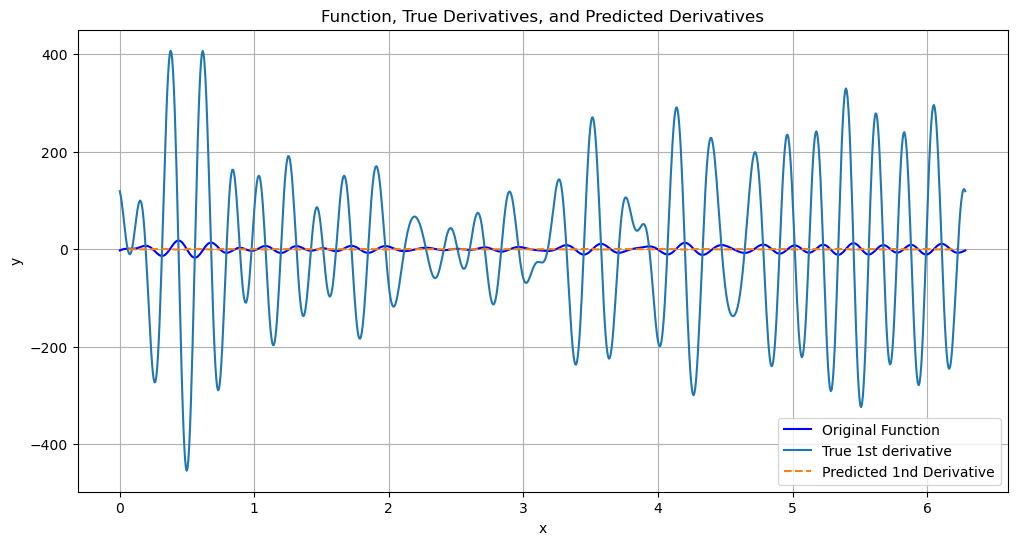

In [24]:
plot_output(f0, dataset=train_dataset_h, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_hf_output', save=save)

## Metrics (MSE and NMSE)

In [25]:
def compute_mse(dataloader, model):
    """
    Takes in a dataloader and a model to compute MSE.
    """

    model.eval()
    all_outputs = []
    all_targets = []

    for function, deriv in dataloader:
        function = function.unsqueeze(1)
        deriv = deriv.unsqueeze(1)

        # Compute model output
        model_output = model(function)
        all_targets.append(deriv)

        # Collect outputs
        all_outputs.append(model_output)

    # Concatenate all collected outputs and targets
    all_outputs = torch.cat(all_outputs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Compute MSE
    mse = torch.mean((all_targets - all_outputs) ** 2)
    nmse = mse / torch.mean(all_targets ** 2)

    return mse.item(), nmse.item()

Loss over low frequency functions

**Note: the values displayed directly below don't mean anything because they're using an untrained model**

In [26]:
print(f"MSE over low freq train functions: {compute_mse(train_dataloader_l, f0)[0]}")
print(f"NMSE over low freq train functions: {compute_mse(train_dataloader_l, f0)[1]}\n")

print(f"MSE over low freq test functions: {compute_mse(test_dataloader_l, f0)[0]}")
print(f"NMSE over low freq test functions: {compute_mse(test_dataloader_l, f0)[1]}")


MSE over low freq train functions: 112.37535095214844
NMSE over low freq train functions: 1.0002650022506714

MSE over low freq test functions: 117.25035095214844
NMSE over low freq test functions: 1.000205159187317


Loss over general frequency functions

In [27]:
print(f"MSE over general freq train functions: {compute_mse(train_dataloader_g, f0)[0]}")
print(f"NMSE over general freq train functions: {compute_mse(train_dataloader_g, f0)[1]}\n")

print(f"MSE over general freq test functions: {compute_mse(test_dataloader_g, f0)[0]}")
print(f"NMSE over general freq test functions: {compute_mse(test_dataloader_g, f0)[1]}\n")

MSE over general freq train functions: 27.255739212036133
NMSE over general freq train functions: 1.0007922649383545

MSE over general freq test functions: 27.178239822387695
NMSE over general freq test functions: 1.0007846355438232



Loss over high frequency functions

In [28]:
print(f"MSE over high freq train functions: {compute_mse(train_dataloader_h, f0)[0]}")
print(f"NMSE over high freq train functions: {compute_mse(train_dataloader_h, f0)[1]}\n")

print(f"MSE over high freq test functions: {compute_mse(test_dataloader_h, f0)[0]}")
print(f"NMSE over high freq test functions: {compute_mse(test_dataloader_h, f0)[1]}\n")

MSE over high freq train functions: 28146.224609375
NMSE over high freq train functions: 0.9999207854270935

MSE over high freq test functions: 27007.658203125
NMSE over high freq test functions: 0.9999188184738159



Function that includes all these print statements

In [29]:
def print_and_store_metrics(f0):
    return compute_mse(train_dataloader_l, f0)[1], compute_mse(train_dataloader_g, f0)[1], compute_mse(train_dataloader_h, f0)[1]

### Model training

In [65]:
model1 = SimpleCNN()

In [66]:
train_losses, test_losses = [], []

def model_training(model, train_dataloader, test_dataloader, num_epochs,\
    split_freq=None, filename=None, save=None, order=None):
    train_losses = []
    test_losses = []

    low_freq_nmses = []
    general_freq_nmses = []
    high_freq_nmses = []
    epoch_list = []

    lr = 1e-3

    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        if epoch % split_freq == 0:
            l, g, h = print_and_store_metrics(model)
            low_freq_nmses.append(l)
            general_freq_nmses.append(g)
            high_freq_nmses.append(h)
            epoch_list.append(epoch)

        for batch_functions, batch_derivatives in train_dataloader:
            batch_functions = batch_functions.unsqueeze(1)
            batch_derivatives = batch_derivatives.unsqueeze(1)

            outputs = model(batch_functions)
            loss = criterion(outputs, batch_derivatives)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        model.eval()
        with torch.no_grad():
            for b_test_functions, b_test_derivatives in test_dataloader:
                b_test_functions = b_test_functions.unsqueeze(1)
                b_test_derivatives = b_test_derivatives.unsqueeze(1)

                test_outputs = model(b_test_functions)
                batch_test_loss = criterion(test_outputs, b_test_derivatives)

                test_loss += batch_test_loss.item()

        test_loss /= len(test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    print(f"Training finished for {order}st derivative")

    plt.figure(figsize=(10, 6))
    plt.plot(epoch_list, low_freq_nmses, label='Low freq NMSE')
    plt.plot(epoch_list, general_freq_nmses, label='General freq NMSE')
    plt.plot(epoch_list, high_freq_nmses, label='High freq NMSE')

    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('NMSE')
    plt.title('NMSEs of different frequencies during training')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()
    if save:
        plt.savefig(filename)  

    return train_losses, test_losses

Epoch [1/2000], Train Loss: 27.1872, Test Loss: 26.6279
Epoch [2/2000], Train Loss: 26.2877, Test Loss: 25.6116
Epoch [3/2000], Train Loss: 24.8495, Test Loss: 23.6571
Epoch [4/2000], Train Loss: 22.3703, Test Loss: 20.7180
Epoch [5/2000], Train Loss: 19.2682, Test Loss: 17.1302
Epoch [6/2000], Train Loss: 15.9178, Test Loss: 13.8238
Epoch [7/2000], Train Loss: 12.9000, Test Loss: 11.1413
Epoch [8/2000], Train Loss: 10.5205, Test Loss: 9.2656
Epoch [9/2000], Train Loss: 8.8537, Test Loss: 7.6920
Epoch [10/2000], Train Loss: 7.5552, Test Loss: 6.5590
Epoch [11/2000], Train Loss: 6.6170, Test Loss: 5.7212
Epoch [12/2000], Train Loss: 5.8338, Test Loss: 5.0122
Epoch [13/2000], Train Loss: 5.3078, Test Loss: 4.5979
Epoch [14/2000], Train Loss: 4.8553, Test Loss: 4.0753
Epoch [15/2000], Train Loss: 4.3628, Test Loss: 3.7827
Epoch [16/2000], Train Loss: 3.9465, Test Loss: 3.3797
Epoch [17/2000], Train Loss: 3.5919, Test Loss: 3.0557
Epoch [18/2000], Train Loss: 3.2249, Test Loss: 2.7630
Epoc

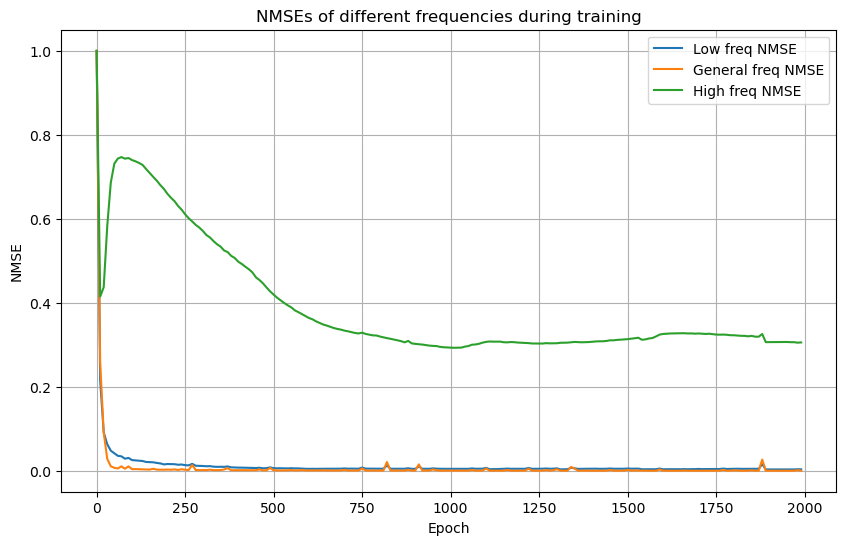

<Figure size 640x480 with 0 Axes>

In [67]:
train_losses, test_losses = model_training(model1, train_dataloader_g, test_dataloader_g,\
    num_epochs=2000, split_freq=10, filename='../plots/spectral_bias/f0_E2000_phased_training',\
    save=save, order='first')
torch.save(f0.state_dict(), f'../../models/{model_name}_E{num_epochs}_phased_training.pth')

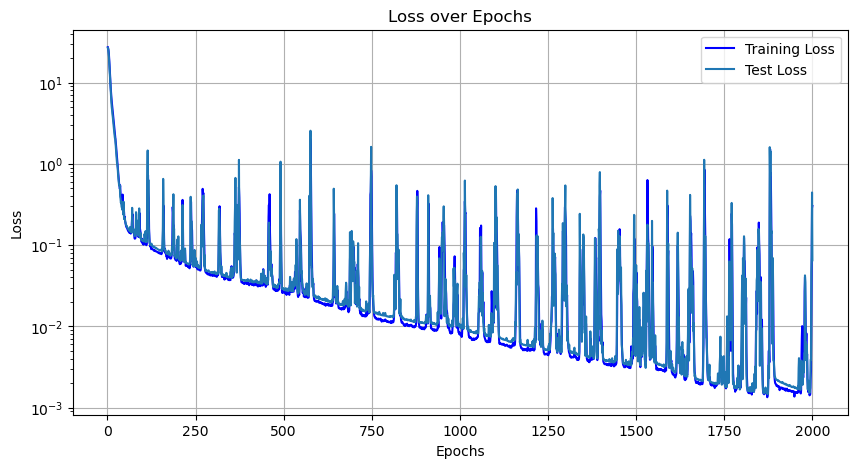

In [68]:
plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

## Training CNN with one layer

In [49]:
class OneLayerCNN(nn.Module):
    def __init__(self):
        super(OneLayerCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        return x

In [40]:
model2 = OneLayerCNN()

Epoch [1/10000], Train Loss: 34.5424, Test Loss: 33.5653
Epoch [2/10000], Train Loss: 33.9875, Test Loss: 33.1160
Epoch [3/10000], Train Loss: 33.7612, Test Loss: 32.6860
Epoch [4/10000], Train Loss: 33.1809, Test Loss: 32.2814
Epoch [5/10000], Train Loss: 32.5268, Test Loss: 31.9009
Epoch [6/10000], Train Loss: 32.5337, Test Loss: 31.5442
Epoch [7/10000], Train Loss: 31.8030, Test Loss: 31.2056
Epoch [8/10000], Train Loss: 31.2118, Test Loss: 30.8886
Epoch [9/10000], Train Loss: 31.2189, Test Loss: 30.5922
Epoch [10/10000], Train Loss: 31.1149, Test Loss: 30.3176
Epoch [11/10000], Train Loss: 30.4001, Test Loss: 30.0554
Epoch [12/10000], Train Loss: 30.3846, Test Loss: 29.8148
Epoch [13/10000], Train Loss: 29.9568, Test Loss: 29.5906
Epoch [14/10000], Train Loss: 29.9500, Test Loss: 29.3828
Epoch [15/10000], Train Loss: 29.6014, Test Loss: 29.1909
Epoch [16/10000], Train Loss: 29.3503, Test Loss: 29.0132
Epoch [17/10000], Train Loss: 29.4497, Test Loss: 28.8491
Epoch [18/10000], Train

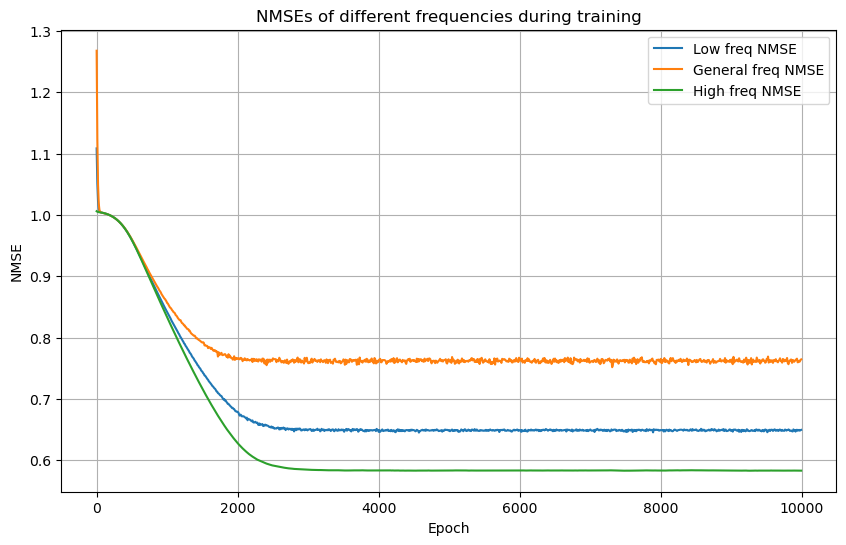

In [41]:
train_losses, test_losses = model_training(model2, train_dataloader_g, test_dataloader_g,\
    num_epochs=10000, split_freq=10, filename='../plots/spectral_bias/f0_E1000_one_layer',\
        order='first')

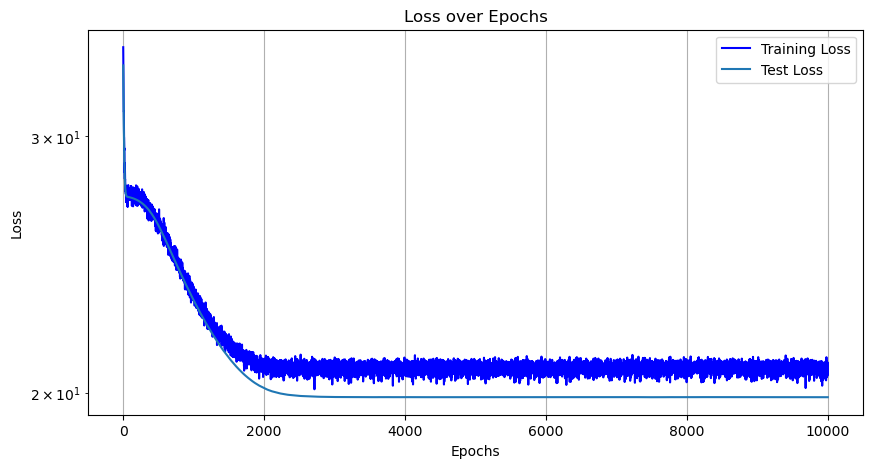

In [47]:
plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias',\
    filename='f0_E10000_one_layer', save=save)

## Plot results using trained models

3-layer conv

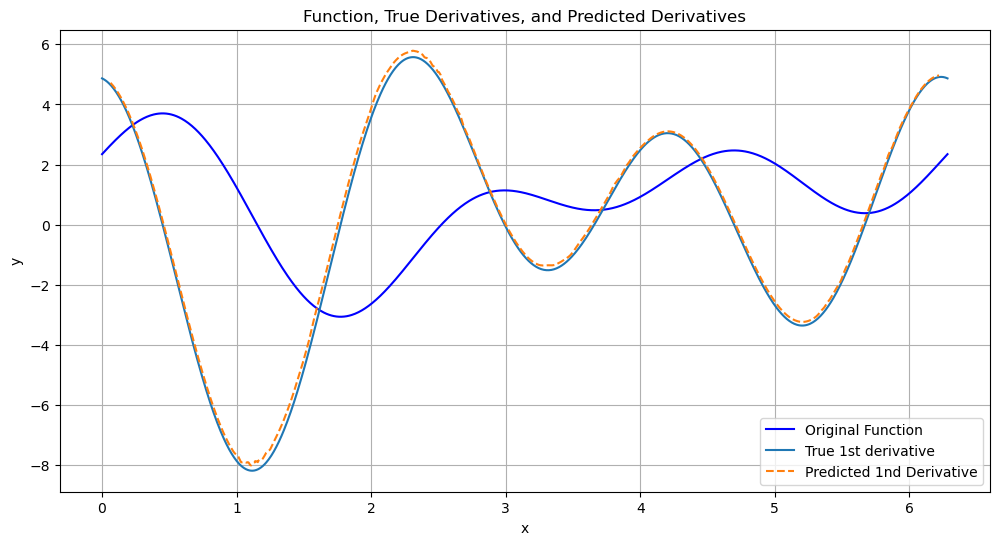

In [70]:
plot_output(model1, dataset=train_dataset_g, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_gf_output', save=save)

One-layer conv

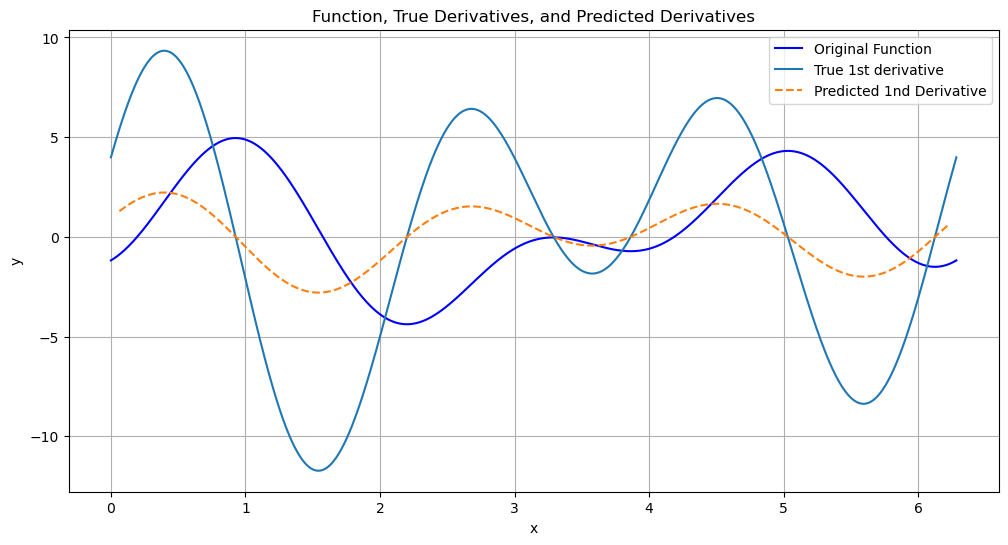

In [72]:
plot_output(model2, dataset=train_dataset_g, order=1,\
    save_dir='../plots/spectral_bias',\
        filename=f'{model_name}_E{num_epochs}_one_layer_output', save=save)

## Model weights

3-layer

In [74]:
# for param in model1.parameters():
#   print(param.data)

1-layer

In [75]:
for param in model2.parameters():
  print(param.data)

tensor([[[-18.8403,  -0.2068,  19.0475]]])
tensor([-0.0004])


2D kernel

In [91]:
class OneLayerPaddedCNN(nn.Module):
    def __init__(self):
        super(OneLayerPaddedCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 1, kernel_size=2, padding=0, bias=False) 

    def forward(self, x):
        # Manually pad the input on one side
        x = F.pad(x, (1, 0))  # Add padding of 1 on the left side of the input
        x = self.conv1(x)
        return x


In [117]:
model_kernel_2 = OneLayerPaddedCNN()
model_kernel_2.conv1.weight.data = torch.tensor([[[-21.41, 21.41]]])

Epoch [1/1000], Train Loss: 23.2197, Test Loss: 22.9635
Epoch [2/1000], Train Loss: 23.8786, Test Loss: 22.9637
Epoch [3/1000], Train Loss: 23.5934, Test Loss: 22.9634
Epoch [4/1000], Train Loss: 23.4418, Test Loss: 22.9635
Epoch [5/1000], Train Loss: 23.7797, Test Loss: 22.9634
Epoch [6/1000], Train Loss: 23.7564, Test Loss: 22.9634
Epoch [7/1000], Train Loss: 23.7525, Test Loss: 22.9634
Epoch [8/1000], Train Loss: 23.6379, Test Loss: 22.9634
Epoch [9/1000], Train Loss: 23.7423, Test Loss: 22.9634
Epoch [10/1000], Train Loss: 23.5496, Test Loss: 22.9634
Epoch [11/1000], Train Loss: 23.4224, Test Loss: 22.9634
Epoch [12/1000], Train Loss: 23.7424, Test Loss: 22.9635
Epoch [13/1000], Train Loss: 23.5715, Test Loss: 22.9635
Epoch [14/1000], Train Loss: 23.6076, Test Loss: 22.9635
Epoch [15/1000], Train Loss: 23.6821, Test Loss: 22.9635
Epoch [16/1000], Train Loss: 23.5934, Test Loss: 22.9635
Epoch [17/1000], Train Loss: 23.6359, Test Loss: 22.9634
Epoch [18/1000], Train Loss: 23.4393, Te

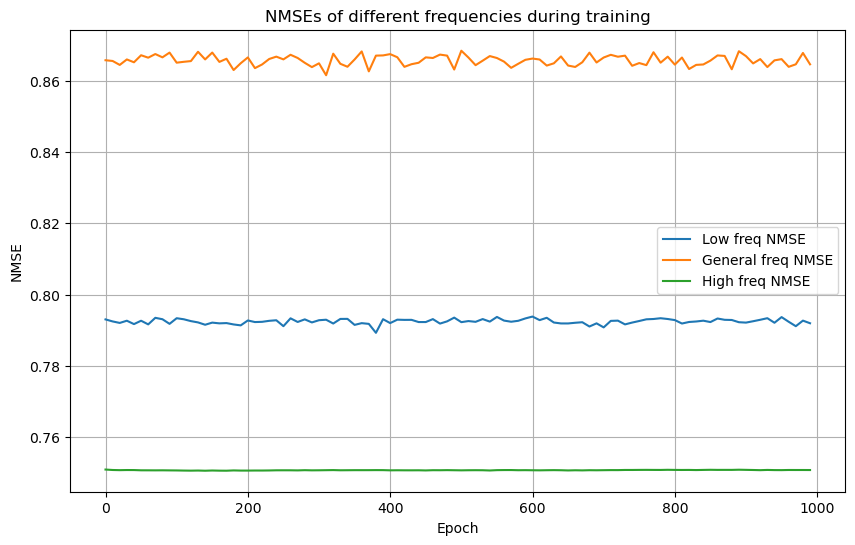

In [118]:
train_losses, test_losses = model_training(model_kernel_2, train_dataloader_g, test_dataloader_g,\
    num_epochs=1000, split_freq=10, filename='../plots/spectral_bias/f0_E1000_one_layer_kernel_2',\
        order='first')

In [119]:
for param in model_kernel_2.parameters():
  print(param.data)

tensor([[[-21.4227,  21.3990]]])


In [89]:
model_kernel_2.conv1.weight.data = torch.tensor([[[1000.0, -1000.0]]])